# Install Dependencies.

In [163]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [164]:
import tensorflow as tf
import os

In [165]:
#Limit tensorflow using all our GPU and prevent Out of Memory Error.
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory

In [166]:
gpus = tf.config.experimental.list_physical_devices('CPU')

# Remove Dodgy Images.

In [167]:
import cv2
import imghdr

In [168]:
data_dir = 'data'

In [169]:
image_exts = ['jpeg','jpg','png','bmp']

In [170]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path = os.path.join(data_dir,image_class,image)
        try:
            img = cv2.imread(image_path) #reads the image.
            tip = imghdr.what(image_path)  #
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

# Load Data

In [171]:
import numpy as py
from matplotlib import pyplot as plt

In [172]:
# Automatically creates a dataset and also does pre-processing.
# Building our data pipeline.
data = tf.keras.utils.image_dataset_from_directory('data')

Found 158 files belonging to 2 classes.


In [173]:
#Store it in a dataset.
data_iterator = data.as_numpy_iterator()

In [174]:
#Images stored.
batch = data_iterator.next()

In [175]:
len(batch)
# Batch as 2 parts:
# Images-part1
# Label-part2

2

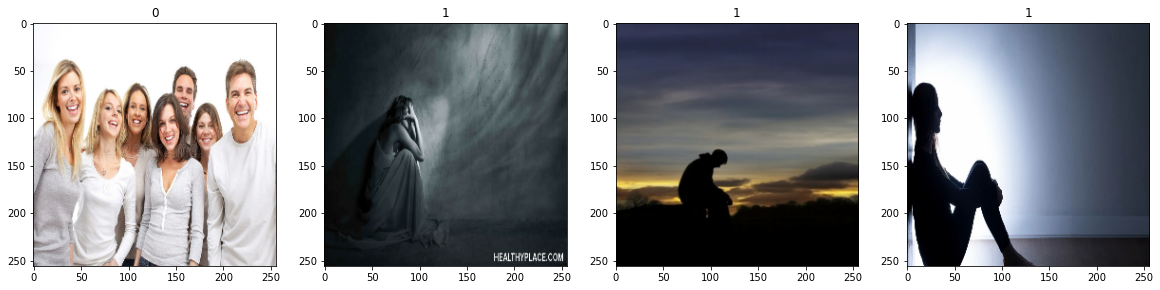

In [176]:
# Class 1 sign is assigned to sad images.
# Class 0 is assigned to happy images.
# To view our images.
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# PART-2 : PREPROCESSING THE DATA

In [177]:
# Divide by 255 to get values between 0 and 1.Scaling the images.
# But we dont want to do this again and again for the data pipeline.
# So we can use map funcion instead, to do data scaling inside the data pipeline.

# Scale Data: transformation:
data = data.map(lambda x,y:(x/255,y))

In [178]:
# Dont run prev step many times as it divides by 255 everytime.
data.as_numpy_iterator().next()[0].max()

1.0

In [179]:
# Split data

# Training Set - 70%
# Validation Set - 20%

# Used Post Training.
# Testing Set - 10%

len(data)
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.2)+1

In [180]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [181]:
len(test)

1

# PART-3 Deep Learning Neural Network

In [182]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

In [183]:
model = Sequential()

# Input layer
model.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu'))

# Output Layer - 0 or 1.
model.add(Dense(1,activation='sigmoid'))


In [184]:
# adam - optimiser
model.compile('adam',loss=tf.losses.BinaryCrossentropy(),metrics = ['accuracy'])

In [185]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

# Train

In [186]:
logdir = 'logs'

In [187]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [188]:
# fit: take in training data.
hist = model.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
3/3 [==============================] - 17s 4s/step - loss: 1.3989 - accuracy: 0.5729 - val_loss: 1.3088 - val_accuracy: 0.3438
Epoch 2/20
3/3 [==============================] - 8s 2s/step - loss: 1.0135 - accuracy: 0.4271 - val_loss: 0.7135 - val_accuracy: 0.5000
Epoch 3/20
3/3 [==============================] - 9s 3s/step - loss: 0.6953 - accuracy: 0.5938 - val_loss: 0.6627 - val_accuracy: 0.6250
Epoch 4/20
3/3 [==============================] - 9s 3s/step - loss: 0.6624 - accuracy: 0.6562 - val_loss: 0.6007 - val_accuracy: 0.6562
Epoch 5/20
3/3 [==============================] - 7s 2s/step - loss: 0.6340 - accuracy: 0.5208 - val_loss: 0.5708 - val_accuracy: 0.5938
Epoch 6/20
3/3 [==============================] - 8s 2s/step - loss: 0.5702 - accuracy: 0.7396 - val_loss: 0.6457 - val_accuracy: 0.6875
Epoch 7/20
3/3 [==============================] - 8s 2s/step - loss: 0.4709 - accuracy: 0.7917 - val_loss: 0.4752 - val_accuracy: 0.8125
Epoch 8/20
3/3 [========================

### You want your val_loss and loss to decrease gradually otherwise the model might overfit the training data

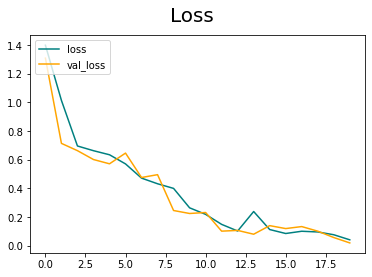

In [189]:
#Visualizing loss:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal',label='loss')
plt.plot(hist.history['val_loss'], color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

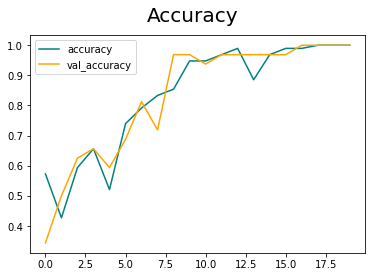

In [190]:
#Visualizing Accuracy:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

# PART 4- Evaluate Performance

### Evaluate

In [191]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy

In [192]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [193]:
len(test)

1

In [194]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 [==============================] - 1s 537ms/step


In [195]:
print('Precision: ',pre.result().numpy())
print('Recall: ',re.result().numpy())
print('Accuracy: ',acc.result().numpy())

Precision:  1.0
Recall:  1.0
Accuracy:  1.0


### Test

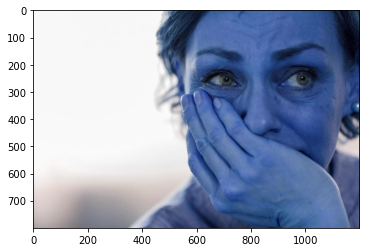

In [219]:
img = cv2.imread('sadTest.jpg')
plt.imshow(img)
plt.show()

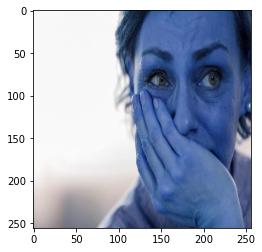

In [220]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [221]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 38ms/step


In [222]:
yhat

array([[0.91773325]], dtype=float32)

In [223]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# PART-5 : SAVE THE MODEL

In [224]:
from tensorflow.keras.models import load_model

In [225]:
model.save(os.path.join('models','happysadmodel.h5'))
# h5- similar to zip a file. We can reaload this model anytime.

In [227]:
#reload the model
new_model = load_model(os.path.join('models','happysadmodel.h5'))

In [230]:
yhat_new = new_model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 41ms/step


In [231]:
if yhat_new > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad
